<a href="https://colab.research.google.com/github/pratikiiitb2013/Amplify_Demo/blob/main/Dell_AmplifyProgram_NLP_NN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_excel('/content/dici_with_levels - Main training dataset.xlsx')

df['OPP_NM_cleanUp'] = [re.sub('[^\x00-\x7F]+', '', str(_)) for _ in df.OPP_NM]
df['OPP_NM_cleanUp'] = [re.sub('\W+|_', ' ', str(_)) for _ in df.OPP_NM_cleanUp]
df['OPP_NM_cleanUp'] = [re.sub('\w*\d\w*', '', str(_)) for _ in df.OPP_NM_cleanUp]

df['SLTN_NM_DESC'] = [re.sub('[^\x00-\x7F]+', '', str(_)) for _ in df.SLTN_NM_DESC]
df['SLTN_NM_DESC'] = [re.sub('\W+|_', ' ', str(_)) for _ in df.SLTN_NM_DESC]
df['SLTN_NM_DESC'] = [re.sub('\w*\d\w*', '', str(_)) for _ in df.SLTN_NM_DESC]

df['SLTN_TYPE_DESC'] = [re.sub('[^\x00-\x7F]+', '', str(_)) for _ in df.SLTN_TYPE_DESC]
df['SLTN_TYPE_DESC'] = [re.sub('\W+|_', ' ', str(_)) for _ in df.SLTN_TYPE_DESC]
df['SLTN_TYPE_DESC'] = [re.sub('\w*\d\w*', '', str(_)) for _ in df.SLTN_TYPE_DESC]

df['DELL_ACCT_NAME'] = [re.sub('[^\x00-\x7F]+', '', str(_)) for _ in df.DELL_ACCT_NAME]
df['DELL_ACCT_NAME'] = [re.sub('\W+|_', ' ', str(_)) for _ in df.DELL_ACCT_NAME]
df['DELL_ACCT_NAME'] = [re.sub('\w*\d\w*', '', str(_)) for _ in df.DELL_ACCT_NAME]

df.OPP_NM_cleanUp = df.OPP_NM_cleanUp.replace('\s+', ' ', regex=True)
df.SLTN_NM_DESC = df.SLTN_NM_DESC.replace('\s+', ' ', regex=True)
df.SLTN_TYPE_DESC = df.SLTN_TYPE_DESC.replace('\s+', ' ', regex=True)
df.DELL_ACCT_NAME = df.DELL_ACCT_NAME.replace('\s+', ' ', regex=True)

df['OPP_NM_cleanUp'] = df['OPP_NM_cleanUp'].str.lower()
df['SLTN_NM_DESC'] = df['SLTN_NM_DESC'].str.lower()
df['SLTN_TYPE_DESC'] = df['SLTN_TYPE_DESC'].str.lower()
df['DELL_ACCT_NAME'] = df['DELL_ACCT_NAME'].str.lower()

df['FLG'] = df.apply(lambda x: x.DELL_ACCT_NAME in x.OPP_NM_cleanUp, axis=1)
df['Combined_OPP_NM_ACC_NM'] = np.where(df['FLG']==False, df['OPP_NM_cleanUp'] + ' ' + df['DELL_ACCT_NAME'], df['OPP_NM_cleanUp'])
df['final_combined'] = df['Combined_OPP_NM_ACC_NM'] + " " + df['SLTN_NM_DESC'].fillna('') + " " + df['SLTN_TYPE_DESC'].fillna('')
df.final_combined = df.final_combined.replace('\s+', ' ', regex=True)

In [3]:
df.dici_Yes_No.value_counts()

LVL8    30582
LVL7    19633
LVL6    13069
LVL5     2240
LVL3     1981
LVL2     1893
LVL4      587
Name: dici_Yes_No, dtype: int64

In [4]:
import random
import torch, torchtext
from torchtext.legacy import data
SEED = 43
torch.manual_seed(SEED)

In [5]:
TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField()

In [6]:
fields = [('text', TEXT),('label',LABEL)]
example = [data.Example.fromlist([df.final_combined[i],df.dici_Yes_No[i]], fields) for i in range(df.shape[0])] 
textDataset = data.Dataset(example, fields)
(train, valid) = textDataset.split(split_ratio=[0.85, 0.15], random_state=random.seed(SEED))

In [ ]:
print(f'Number of training examples: {len(train)}')
print(f'Number of testing examples: {len(valid)}')

In [ ]:
print(vars(train.examples[0]))

In [7]:
MAX_VOCAB_SIZE = 25_000
TEXT.build_vocab(train, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")
print('Top 10 words appreared repeatedly :', list(TEXT.vocab.freqs.most_common(20)))
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

In [8]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train, valid), 
    batch_size = BATCH_SIZE,
    sort=False,
    device = device)

In [9]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(TEXT.vocab.stoi, tokens)

#Model
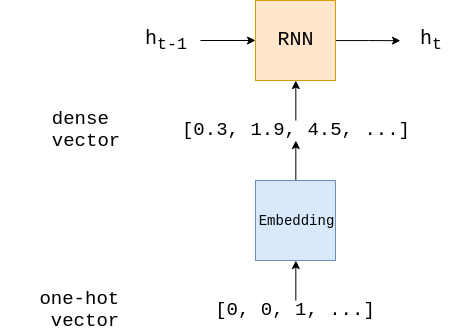

#RNN
####We'll be using a <b>recurrent neural network (RNN)</b> as they are commonly used in analysing sequences. An RNN takes in sequence of words, <b><i>X={$x_{1}$, ..., $x_{T}$}</i></b> , one at a time, and produces a hidden state, <i><b>h</b></i> , for each word. We use the RNN recurrently by feeding in the current word $x_{t}$ as well as the hidden state from the previous word, $h_{t-1}$, to produce the next hidden state, $h_{t}$.
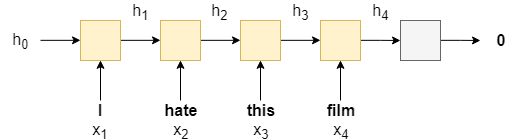

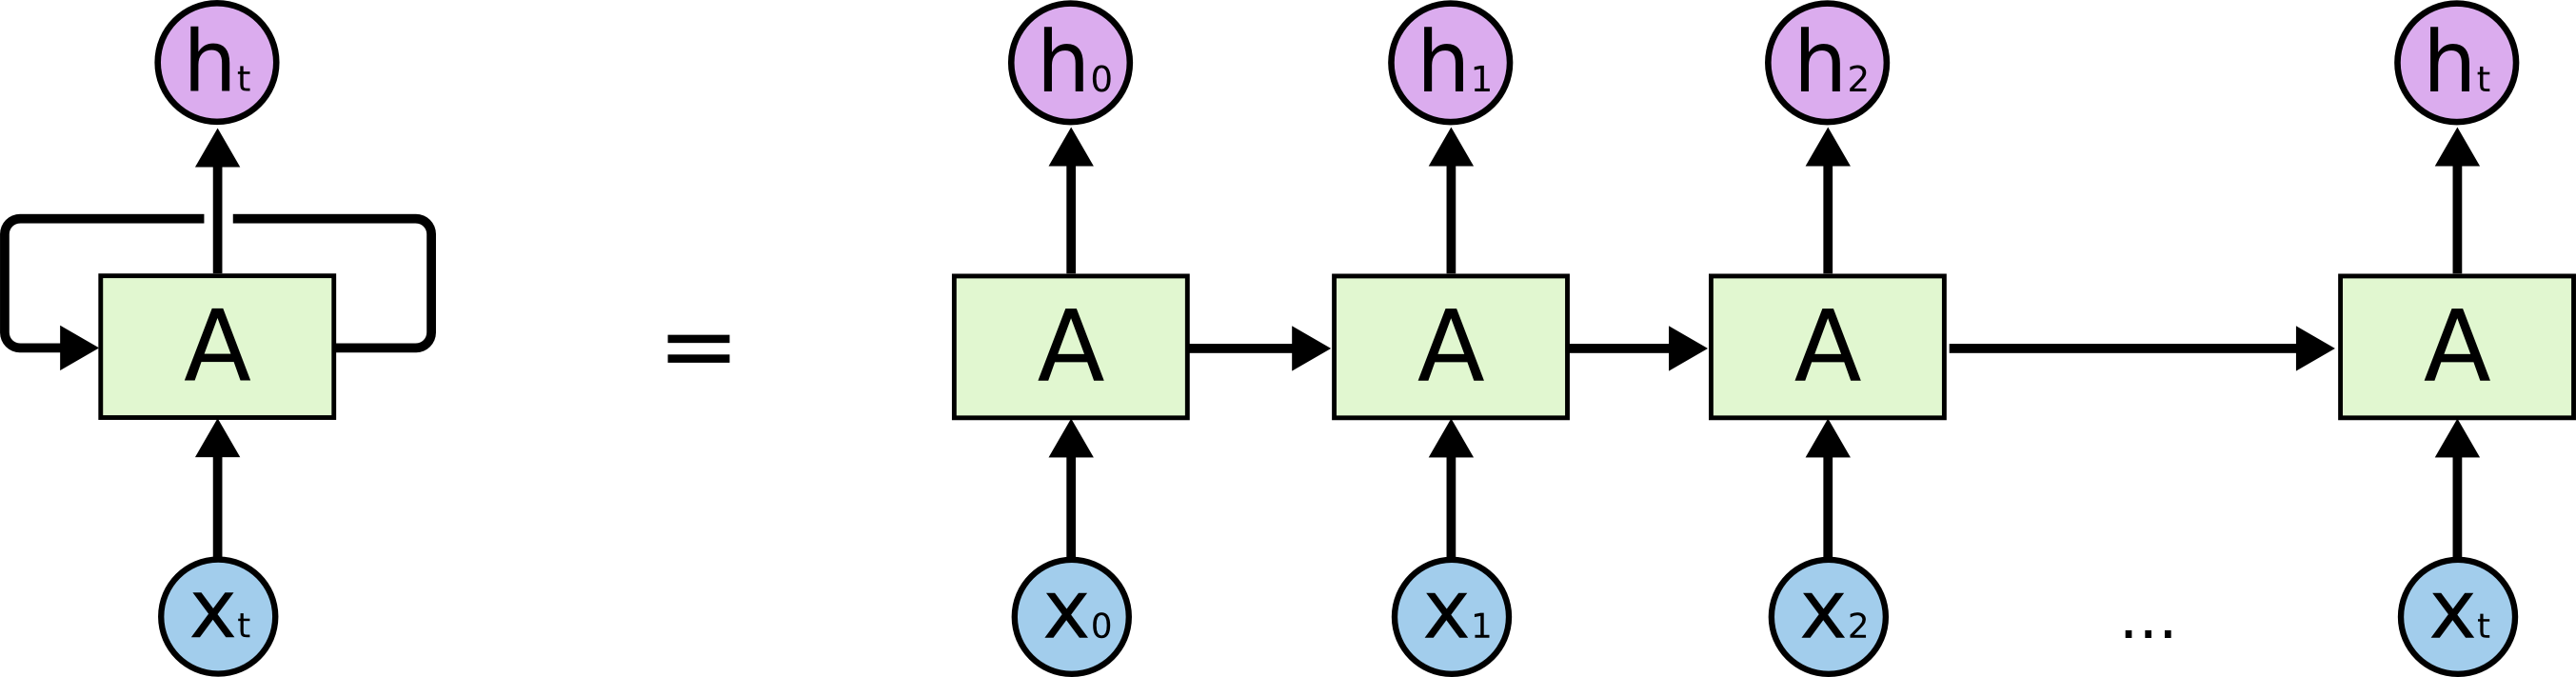



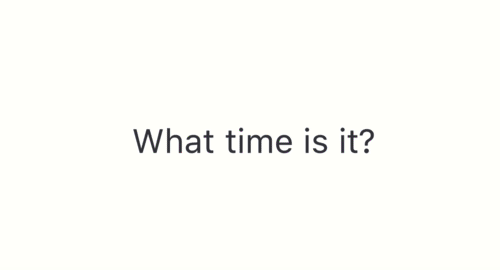

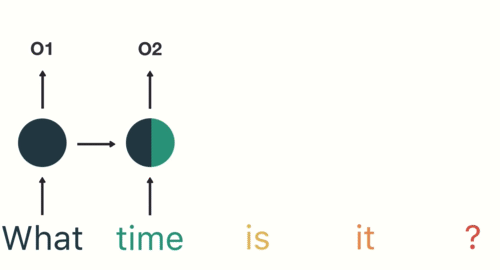

In [10]:
import torch.nn as nn

class classifier(nn.Module):
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        #text = [sent len, batch size]
        embedded = self.embedding(text)
        #embedded = [sent len, batch size, emb dim]
        output, hidden = self.rnn(embedded)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        return self.fc(hidden.squeeze(0))

In [11]:
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 256
num_output_nodes = 7

model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes)
print(model)


classifier(
  (embedding): Embedding(25002, 100)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=7, bias=True)
)


In [12]:
#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,593,647 trainable parameters


In [13]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [14]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [15]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()    
        predictions = model(batch.text)
        loss = criterion(predictions, batch.label)
        acc = categorical_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [16]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text)
            loss = criterion(predictions, batch.label)
            acc = categorical_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
N_EPOCHS = 10
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 1.391 | Train Acc: 43.11%
	 Val. Loss: 1.405 |  Val. Acc: 43.71%
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 1.373 | Train Acc: 44.70%
	 Val. Loss: 1.400 |  Val. Acc: 38.99%
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 1.387 | Train Acc: 43.76%
	 Val. Loss: 1.385 |  Val. Acc: 43.66%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 1.386 | Train Acc: 43.58%
	 Val. Loss: 1.395 |  Val. Acc: 43.19%
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 1.380 | Train Acc: 44.10%
	 Val. Loss: 1.395 |  Val. Acc: 43.66%
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 1.383 | Train Acc: 43.45%
	 Val. Loss: 1.387 |  Val. Acc: 43.64%
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 1.373 | Train Acc: 44.23%
	 Val. Loss: 1.416 |  Val. Acc: 43.50%
Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 1.344 | Train Acc: 46.07%
	 Val. Loss: 1.390 |  Val. Acc: 43.50%
Epoch: 09 | Epoch Time: 0m 7s
	Train Loss: 1.373 | Train Acc: 44.30%
	 Val. Loss: 1.357 |  Val. Acc: 46.75%
Epoch: 10 | Epoch Time: 0m 7